## Projecting Cohort Fertility Rates

This notebook uses PyMC to model and predict fertility rates in the United States, using preprocessed data from the US Census.

Background article on fertility rates: "[Why the total fertility rate doesn't necessarily tell us the number of births women eventually have](https://ourworldindata.org/total-fertility-rate-births-per-woman)" 

**Note:** Run `process_cps.ipynb` first to generate the preprocessed data file.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/BayesFertility/blob/main/fertility_cps.ipynb)

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/BayesFertility/raw/main/utils.py")

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm

from utils import decorate, value_counts, save_baseline_results, load_baseline_results
import os

# Set up debug log for recording important results
os.makedirs('../jb/tables', exist_ok=True)
os.makedirs('../jb/figs', exist_ok=True)
debug_log = open('../jb/tables/fertility_cps4_log.txt', 'w')

def log_and_print(message, log_file=None):
    """
    Helper function to write to debug log and print to notebook.
    """
    if log_file is None:
        log_file = globals().get('debug_log', None)
    
    if log_file:
        log_file.write(message + "\n")
        log_file.flush()
    
    print(message)

log_and_print("Fertility CPS Model v4.0 Log")
log_and_print("=" * 80)
log_and_print("")

Fertility CPS Model v4.0 Log



## Load Preprocessed Data

Load the preprocessed data from the preprocessing notebook.

In [3]:
filename = "../data/fertility_cps_preprocessed.h5"

# Load the aggregated data
sum_df = pd.read_hdf(filename, key='sum_df')
count_df = pd.read_hdf(filename, key='count_df')
cfr_cps = pd.read_hdf(filename, key='cfr_cps')

# Load labels
age_labels = pd.read_hdf(filename, key='age_labels').values
cohort_labels = pd.read_hdf(filename, key='cohort_labels').values

# Load metadata
metadata = pd.read_hdf(filename, key='metadata')
cutoff_year = int(metadata['cutoff_year'])

log_and_print(f"Loaded preprocessed data from {filename}")
log_and_print(f"  Cutoff year: {cutoff_year}")
log_and_print(f"  Shape: {sum_df.shape}")
log_and_print(f"  Number of cohorts: {len(cohort_labels)}")
log_and_print(f"  Cohort range: {cohort_labels.min()} to {cohort_labels.max()}")
log_and_print(f"  Number of age groups: {len(age_labels)}")
log_and_print(f"  Age range: {age_labels.min()} to {age_labels.max()}")
log_and_print("")

Loaded preprocessed data from ../data/fertility_cps_preprocessed.h5
  Cutoff year: 2024
  Shape: (30, 14)
  Number of cohorts: 30
  Cohort range: 1922 to 2009
  Number of age groups: 14
  Age range: 15 to 54



## The Model

For the most recent generations, we have limited data.
To project what future fertility rates will look like, we'll use a model to estimate cohort and age effects, then use the model to generate predictions.

The following PyMC model extends the basic log-linear model of cohort and age effects with a **timing shift parameter** that allows the age-fertility curve to shift earlier or later for different cohorts.

**Model components:**
- $\alpha_i$: Cohort effect indicating overall fertility level
- $\beta_j$: Age effect indicating age-specific fertility pattern
- $\gamma_i$: **New timing shift parameter** indicating whether a cohort has children earlier or later

**Base model:** $\lambda_{ij} = \exp(\alpha_i + \beta_j)$

**Extended model with timing shifts:** $\lambda_{ij} = \exp(\alpha_i + \beta_j + \gamma_i \times \text{age\_centered}_j)$

Where $\text{age\_centered}_j = \text{age}_j - \overline{\text{age}}$ is the age group label centered to have mean zero.

**Interpretation:**
- When $\gamma_i > 0$: Cohort $i$ has delayed childbearing (fertility shifts to older ages)
- When $\gamma_i < 0$: Cohort $i$ has earlier childbearing (fertility shifts to younger ages)
- When $\gamma_i = 0$: No timing shift (reduces to base model)

The timing shift adds a linear (in age) term to log-fertility. At young ages (negative age_centered), a positive $\gamma$ adds a negative term to log(λ), reducing fertility. At old ages (positive age_centered), a positive $\gamma$ adds a positive term to log(λ), increasing fertility. This shifts the age-fertility curve to older ages.

All parameters ($\alpha$, $\beta$, $\gamma$) are modeled with Gaussian random walks with estimated hyperparameters. The values of $\alpha$ and $\gamma$ are constrained to have mean zero for identifiability.

In [4]:
def make_model(sum_array, count_array, age_centered):
    with pm.Model() as model:
        n_cohorts, n_ages = sum_array.shape

        # Random walk prior for cohort effects with mean constraint
        # Estimate sigma_alpha as a hyperparameter
        sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=0.1)
        alpha = pm.GaussianRandomWalk(
            "alpha",
            sigma=sigma_alpha,
            shape=n_cohorts,
            init_dist=pm.Normal.dist(mu=0, sigma=0.5),
        )

        # Soft constraint to enforce mean zero without hard subtraction
        pm.Potential(
            "zero_mean_alpha_constraint", pm.logp(pm.Normal.dist(0, 0.001), 
                                                  pm.math.mean(alpha))
        )

        # Random walk prior for age effects
        # Estimate sigma_beta as a hyperparameter
        sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.3)
        beta = pm.GaussianRandomWalk(
            "beta",
            sigma=sigma_beta, 
            shape=n_ages,
            init_dist=pm.Normal.dist(mu=0, sigma=1)
        )

        # Random walk prior for timing shift parameters (NEW in v4.0)
        # Estimate sigma_gamma as a hyperparameter
        sigma_gamma = pm.HalfNormal("sigma_gamma", sigma=0.02)
        gamma = pm.GaussianRandomWalk(
            "gamma",
            sigma=sigma_gamma,
            shape=n_cohorts,
            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
        )

        # Soft constraint to enforce mean zero for gamma
        pm.Potential(
            "zero_mean_gamma_constraint", pm.logp(pm.Normal.dist(0, 0.001), 
                                                  pm.math.mean(gamma))
        )

        # Log-linear model with timing shifts (additive in log-space)
        # Base model: log(λ) = α + β
        # Extended: log(λ) = α + β + γ × age_centered
        # age_centered is passed as data (not a parameter), perfectly centered
        log_lambda = alpha[:, None] + beta[None, :] + gamma[:, None] * age_centered[None, :]

        # Final ASBR with timing shifts
        lambda_ = pm.Deterministic("lambda", pm.math.exp(log_lambda))

        # Observed parity depends on the cumulative sum of ASBRs
        cumulative_lambda = pm.math.cumsum(lambda_, axis=1)

        # Likelihood, ignoring unobserved cohort-age pairs
        mask = count_array != 0
        y_obs = pm.Poisson(
            "y_obs", mu=(count_array * cumulative_lambda)[mask], observed=sum_array[mask]
        )
        
        return model

In [5]:
count_array = count_df.to_numpy()
sum_array = sum_df.to_numpy()

Compute the centered age variable for the timing shift model:

In [6]:
# Center age labels perfectly so mean is exactly zero
age_centered = age_labels - age_labels.mean()

print(f"Age labels: {age_labels}")
print(f"Age centered: {age_centered}")
print(f"Mean of age_centered (should be ~0): {age_centered.mean():.10f}")
print(f"Range of age_centered: [{age_centered.min():.1f}, {age_centered.max():.1f}]")

log_and_print(f"Age centering:")
log_and_print(f"  Age labels: {age_labels}")
log_and_print(f"  Age centered: {age_centered}")
log_and_print(f"  Mean: {age_centered.mean():.10f}")
log_and_print(f"  Range: [{age_centered.min():.1f}, {age_centered.max():.1f}]")
log_and_print("")

Age labels: [15 18 21 24 27 30 33 36 39 42 45 48 51 54]
Age centered: [-19.5 -16.5 -13.5 -10.5  -7.5  -4.5  -1.5   1.5   4.5   7.5  10.5  13.5
  16.5  19.5]
Mean of age_centered (should be ~0): 0.0000000000
Range of age_centered: [-19.5, 19.5]
Age centering:
  Age labels: [15 18 21 24 27 30 33 36 39 42 45 48 51 54]
  Age centered: [-19.5 -16.5 -13.5 -10.5  -7.5  -4.5  -1.5   1.5   4.5   7.5  10.5  13.5
  16.5  19.5]
  Mean: 0.0000000000
  Range: [-19.5, 19.5]



To see whether the prior distributions make sense, we'll look at the prior predictive distribution of $\lambda$.

In [7]:
log_and_print(f"Model configuration:")
log_and_print(f"  Version 4.0: Extended model with cohort-specific timing shifts (gamma)")
log_and_print(f"  Hyperparameters: sigma_alpha, sigma_beta, sigma_gamma (all estimated)")
log_and_print("")

Model configuration:
  Version 4.0: Extended model with cohort-specific timing shifts (gamma)
  Hyperparameters: sigma_alpha, sigma_beta, sigma_gamma (all estimated)



In [8]:
model = make_model(sum_array, count_array, age_centered)

In [9]:
with model:
    prior_predictive = pm.sample_prior_predictive(1000)

lambda_prior_samples = (
    prior_predictive.prior["lambda"].stack(sample=("chain", "draw")).values
)

/tmp/ipykernel_604688/1437896971.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_predictive = pm.sample_prior_predictive(1000)
Sampling: [alpha, beta, gamma, sigma_alpha, sigma_beta, sigma_gamma, y_obs]


In [10]:
pd.Series(lambda_prior_samples.flatten()).describe()

count    4.200000e+05
mean     2.530335e+01
std      2.622057e+03
min      1.648492e-06
25%      3.530311e-01
50%      1.000248e+00
75%      2.829495e+00
max      1.126244e+06
dtype: float64

Now let's sample the posterior distribution.
In general, the model samples well.

In [11]:
from utils import load_idata_or_sample

idata_filename = f"nc/fertility_cps_idata_{cutoff_year}_v4.nc"

idata = load_idata_or_sample(
    model, idata_filename, nuts_sampler="nutpie", force_run=False, random_seed=17
)

Loaded idata from nc/fertility_cps_idata_2024_v4.nc


In [12]:
sigma_summary = pm.summary(idata, var_names=["sigma_alpha", "sigma_beta", "sigma_gamma"])
log_and_print(f"Model parameters:")
for idx, row in sigma_summary.iterrows():
    log_and_print(f"  {idx}:")
    log_and_print(f"    mean: {row['mean']:.4f}")
    log_and_print(f"    sd: {row['sd']:.4f}")
    log_and_print(f"    hdi_3%: {row['hdi_3%']:.4f}")
    log_and_print(f"    hdi_97%: {row['hdi_97%']:.4f}")
    log_and_print(f"    r_hat: {row['r_hat']:.4f}")
    log_and_print(f"    ess_bulk: {row['ess_bulk']:.0f}")
    log_and_print(f"    ess_tail: {row['ess_tail']:.0f}")
log_and_print("")
sigma_summary

Model parameters:
  sigma_alpha:
    mean: 0.1490
    sd: 0.0350
    hdi_3%: 0.0860
    hdi_97%: 0.2130
    r_hat: 1.0000
    ess_bulk: 698
    ess_tail: 1414
  sigma_beta:
    mean: 0.7810
    sd: 0.1300
    hdi_3%: 0.5580
    hdi_97%: 1.0340
    r_hat: 1.0000
    ess_bulk: 3304
    ess_tail: 3193
  sigma_gamma:
    mean: 0.0130
    sd: 0.0020
    hdi_3%: 0.0080
    hdi_97%: 0.0170
    r_hat: 1.0000
    ess_bulk: 937
    ess_tail: 1746



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_alpha,0.149,0.035,0.086,0.213,0.001,0.001,698.0,1414.0,1.0
sigma_beta,0.781,0.130,0.558,1.034,0.002,0.002,3304.0,3193.0,1.0
sigma_gamma,0.013,0.002,0.008,0.017,0.000,0.000,937.0,1746.0,1.0


### Cohort effects

Here is a summary of the cohort effects.

In [13]:
alpha_summary = pm.summary(idata, var_names=["alpha"])
log_and_print(f"Cohort effects (alpha) summary:")
log_and_print(f"  Number of cohorts: {len(alpha_summary)}")
log_and_print(f"  Mean range: [{alpha_summary['mean'].min():.4f}, {alpha_summary['mean'].max():.4f}]")
log_and_print(f"  Largest positive effect: cohort {cohort_labels[alpha_summary['mean'].argmax()]} ({alpha_summary['mean'].max():.4f})")
log_and_print(f"  Largest negative effect: cohort {cohort_labels[alpha_summary['mean'].argmin()]} ({alpha_summary['mean'].min():.4f})")
log_and_print(f"  r_hat range: [{alpha_summary['r_hat'].min():.4f}, {alpha_summary['r_hat'].max():.4f}]")
log_and_print(f"  r_hat max: {alpha_summary['r_hat'].max():.4f}")
log_and_print(f"  ess_bulk min: {alpha_summary['ess_bulk'].min():.0f}")
log_and_print(f"  ess_tail min: {alpha_summary['ess_tail'].min():.0f}")
log_and_print("")
alpha_summary

Cohort effects (alpha) summary:
  Number of cohorts: 30
  Mean range: [-0.9540, 0.3760]
  Largest positive effect: cohort 1964 (0.3760)
  Largest negative effect: cohort 2006 (-0.9540)
  r_hat range: [1.0000, 1.0100]
  r_hat max: 1.0100
  ess_bulk min: 358
  ess_tail min: 653



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.002,0.192,-0.390,0.336,0.007,0.004,690.0,1264.0,1.00
alpha[1],0.003,0.186,-0.351,0.348,0.008,0.004,594.0,1059.0,1.01
alpha[2],0.002,0.178,-0.317,0.343,0.008,0.004,556.0,1021.0,1.01
alpha[3],-0.003,0.165,-0.325,0.285,0.007,0.004,566.0,1143.0,1.00
alpha[4],-0.021,0.151,-0.313,0.242,0.006,0.003,583.0,1232.0,1.00
alpha[5],-0.057,0.125,-0.281,0.181,0.005,0.003,682.0,1141.0,1.00
alpha[6],-0.114,0.102,-0.301,0.083,0.003,0.002,939.0,1263.0,1.00
alpha[7],-0.136,0.078,-0.273,0.016,0.002,0.002,1392.0,1715.0,1.00
alpha[8],-0.138,0.064,-0.264,-0.019,0.002,0.001,700.0,1411.0,1.00
alpha[9],-0.062,0.060,-0.173,0.047,0.003,0.001,441.0,992.0,1.01


In [14]:
def forest_plot(summary, labels, **options):
    means = summary["mean"].to_numpy()
    hdi_lower = summary["hdi_3%"].to_numpy()
    hdi_upper = summary["hdi_97%"].to_numpy()

    n_cohorts = len(means)
    x_positions = np.arange(n_cohorts)
    plt.xticks(x_positions, labels, **options)

    plt.errorbar(
        x_positions,
        means,
        yerr=[means - hdi_lower, hdi_upper - means],
        fmt="o",
        markersize=4,
        capsize=2,
        color="C0",
    )

And here's what they look like:

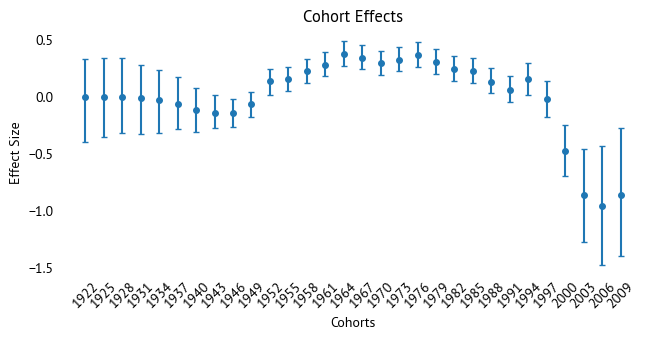

In [15]:
forest_plot(alpha_summary, cohort_labels, rotation=45)
plt.ylabel("Effect Size")
plt.xlabel("Cohorts")
plt.title("Cohort Effects")
plt.tight_layout()
plt.savefig('../jb/figs/cohort_effects_v4.png', dpi=150, bbox_inches='tight')

Qualitatively, the trend is what we expect to see.
The proclivity to have children is highest in the cohorts born in the mid-1930s, who had their babies at the tail end of the baby boom.
It remains relatively stable through the early 1980s, then begins declining, with the decline accelerating for more recent cohorts.

The error bars are wider in the most recent cohorts, where we have less data.
In the most recent cohorts, we see a useful property of the random walk -- if there is not enough data to be confident that there is a change, it assumes that there is no change.
For example, the central estimates for the 2006 and 2009 cohorts are about the same, because there is not enough data in the 2009 cohort to provide strong evidence of a difference.

This is different from what we would see in a hierarchical model, where in the absence of sufficient data, estimates are centered on the overall mean, not the most recent mean.

The model is conservative in the sense that it does not extrapolate trends -- although it looks like this proclivity has declined consistently over the last 30 years, the model does not assume that this trend will continue.

### Timing shift effects (gamma)

Here is a summary of the timing shift parameters (new in v4.0).

In [16]:
gamma_summary = pm.summary(idata, var_names=["gamma"])
log_and_print(f"Timing shift effects (gamma) summary:")
log_and_print(f"  Number of cohorts: {len(gamma_summary)}")
log_and_print(f"  Mean range: [{gamma_summary['mean'].min():.4f}, {gamma_summary['mean'].max():.4f}]")
log_and_print(f"  Largest positive shift: cohort {cohort_labels[gamma_summary['mean'].argmax()]} ({gamma_summary['mean'].max():.4f})")
log_and_print(f"  Largest negative shift: cohort {cohort_labels[gamma_summary['mean'].argmin()]} ({gamma_summary['mean'].min():.4f})")
log_and_print(f"  r_hat range: [{gamma_summary['r_hat'].min():.4f}, {gamma_summary['r_hat'].max():.4f}]")
log_and_print(f"  r_hat max: {gamma_summary['r_hat'].max():.4f}")
log_and_print(f"  ess_bulk min: {gamma_summary['ess_bulk'].min():.0f}")
log_and_print(f"  ess_tail min: {gamma_summary['ess_tail'].min():.0f}")
log_and_print("")
gamma_summary

Timing shift effects (gamma) summary:
  Number of cohorts: 30
  Mean range: [-0.0650, 0.0520]
  Largest positive shift: cohort 1997 (0.0520)
  Largest negative shift: cohort 1934 (-0.0650)
  r_hat range: [1.0000, 1.0100]
  r_hat max: 1.0100
  ess_bulk min: 385
  ess_tail min: 719



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],-0.052,0.020,-0.090,-0.015,0.001,0.0,657.0,1281.0,1.00
gamma[1],-0.055,0.019,-0.092,-0.021,0.001,0.0,565.0,1099.0,1.01
gamma[2],-0.060,0.018,-0.093,-0.026,0.001,0.0,534.0,1011.0,1.01
gamma[3],-0.063,0.017,-0.095,-0.034,0.001,0.0,546.0,1134.0,1.00
gamma[4],-0.065,0.015,-0.093,-0.039,0.001,0.0,561.0,1088.0,1.00
gamma[5],-0.065,0.012,-0.090,-0.044,0.000,0.0,654.0,1157.0,1.00
gamma[6],-0.062,0.010,-0.083,-0.045,0.000,0.0,894.0,1208.0,1.00
gamma[7],-0.053,0.008,-0.068,-0.039,0.000,0.0,1493.0,1782.0,1.00
gamma[8],-0.041,0.006,-0.053,-0.029,0.000,0.0,868.0,1899.0,1.00
gamma[9],-0.024,0.006,-0.035,-0.014,0.000,0.0,505.0,1153.0,1.00


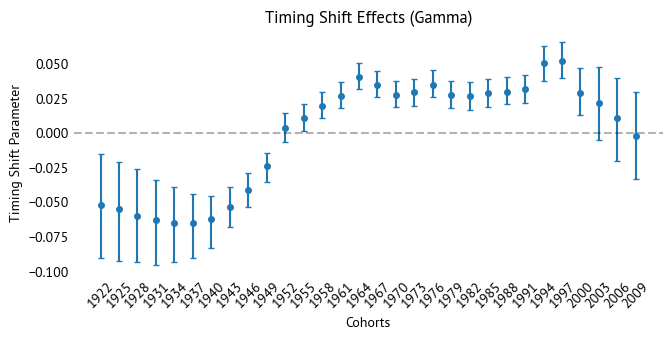

In [17]:
forest_plot(gamma_summary, cohort_labels, rotation=45)
plt.ylabel("Timing Shift Parameter")
plt.xlabel("Cohorts")
plt.title("Timing Shift Effects (Gamma)")
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('../jb/figs/timing_shift_effects.png', dpi=150, bbox_inches='tight')

The timing shift parameters show how the age-fertility curve shifts across cohorts:
- Positive values indicate delayed childbearing (adds to log-fertility at older ages, subtracts at younger ages)
- Negative values indicate earlier childbearing (adds to log-fertility at younger ages, subtracts at older ages)
- Values near zero indicate no shift from the baseline age pattern
- The γ × age_centered term creates a linear tilt in the log-fertility profile

### Age effects

Here is a summary of the age effects.

In [18]:
beta_summary = pm.summary(idata, var_names=["beta"])
log_and_print(f"Age effects (beta) summary:")
log_and_print(f"  Number of age groups: {len(beta_summary)}")
log_and_print(f"  Mean range: [{beta_summary['mean'].min():.4f}, {beta_summary['mean'].max():.4f}]")
log_and_print(f"  Peak fertility age: {age_labels[beta_summary['mean'].argmax()]} ({beta_summary['mean'].max():.4f})")
log_and_print(f"  Lowest fertility age: {age_labels[beta_summary['mean'].argmin()]} ({beta_summary['mean'].min():.4f})")
log_and_print(f"  r_hat range: [{beta_summary['r_hat'].min():.4f}, {beta_summary['r_hat'].max():.4f}]")
log_and_print(f"  r_hat max: {beta_summary['r_hat'].max():.4f}")
log_and_print(f"  ess_bulk min: {beta_summary['ess_bulk'].min():.0f}")
log_and_print(f"  ess_tail min: {beta_summary['ess_tail'].min():.0f}")
log_and_print("")
beta_summary

Age effects (beta) summary:
  Number of age groups: 14
  Mean range: [-7.0480, -1.1280]
  Peak fertility age: 24 (-1.1280)
  Lowest fertility age: 54 (-7.0480)
  r_hat range: [1.0000, 1.0100]
  r_hat max: 1.0100
  ess_bulk min: 421
  ess_tail min: 881



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-3.120,0.053,-3.213,-3.017,0.002,0.001,590.0,1427.0,1.00
beta[1],-1.936,0.037,-2.002,-1.866,0.001,0.001,636.0,1317.0,1.00
beta[2],-1.225,0.024,-1.268,-1.179,0.001,0.000,861.0,1969.0,1.00
beta[3],-1.128,0.020,-1.166,-1.090,0.001,0.000,1404.0,2473.0,1.00
beta[4],-1.186,0.028,-1.238,-1.135,0.001,0.001,582.0,1286.0,1.01
beta[5],-1.383,0.040,-1.461,-1.313,0.002,0.001,448.0,933.0,1.01
beta[6],-1.547,0.053,-1.646,-1.446,0.003,0.001,421.0,881.0,1.01
beta[7],-1.922,0.072,-2.057,-1.794,0.003,0.002,430.0,1041.0,1.01
beta[8],-3.164,0.130,-3.416,-2.934,0.004,0.002,1164.0,2167.0,1.00
beta[9],-5.082,0.423,-5.873,-4.328,0.007,0.007,3453.0,3274.0,1.00


And here's what they look like.

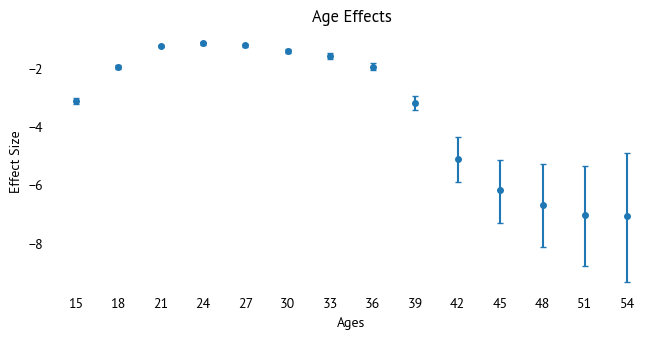

In [19]:
forest_plot(beta_summary, age_labels)

plt.ylabel("Effect Size")
plt.xlabel("Ages")
plt.title("Age Effects")
plt.tight_layout()
plt.savefig('../jb/figs/age_effects_v4.png', dpi=150, bbox_inches='tight')

Qualitatively, the trends here are what we expect: women are most likely to have children in their late 20s to early 30s.

In the age groups where we have less data, the error bars are wider.
And again, the model does not extrapolate trends, so the estimates level off in the oldest groups.

## Prediction

Now we can use the model to generate predictive distributions for each cohort-age group, including retrodictions for the groups where we have data, and predictions for the groups where we have little or none.

In [20]:
with model:
    # Generate posterior predictive samples
    posterior_predictive = pm.sample_posterior_predictive(
        idata, var_names=["lambda"], random_seed=42
    )

    # Compute expected cumulative births for each draw
    lambda_samples = posterior_predictive.posterior_predictive[
        "lambda"
    ].values  # Shape: (chains, draws, n_cohorts, n_ages)

    cumulative_lambda_pred = np.cumsum(
        lambda_samples, axis=-1
    )  # Compute cumulative sum along age axis

/tmp/ipykernel_604688/1989232934.py:3: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior_predictive = pm.sample_posterior_predictive(
Sampling: []


Output()

The result we want is the `cumulative_lambda_pred` array, which contains the expected parity for each cohort-age group.
We can compute the mean by combining the first two axes from the results, averaging over the chains and the draws from each chain.

In [21]:
mean = cumulative_lambda_pred.mean(axis=(0, 1))
hdi = pm.hdi(cumulative_lambda_pred)

I'll put the results in a `DataFrame` so we can see the cohort and age labels.
Reading across the bottom line, we can see the predictions for women born in 2009.

In [22]:
mean_cumulative_rate = pd.DataFrame(mean, index=cohort_labels, columns=age_labels)
mean_cumulative_rate.tail()

,15,18,21,24,27,30,33,36,39,42,45,48,51,54
1997,0.015842,0.076310,0.220273,0.405632,0.610112,0.806621,1.001662,1.158675,1.211989,1.221844,1.226060,1.229390,1.232502,1.237015
2000,0.015594,0.071136,0.194587,0.343066,0.496184,0.633795,0.761599,0.857952,0.888595,0.893912,0.896052,0.897636,0.899017,0.900882
2003,0.012340,0.055279,0.148641,0.258647,0.369930,0.468159,0.557862,0.624463,0.645345,0.648918,0.650344,0.651391,0.652292,0.653504
2006,0.013804,0.060361,0.158547,0.270820,0.381110,0.475693,0.559648,0.620270,0.638763,0.641843,0.643042,0.643901,0.644619,0.645559
2009,0.019671,0.083493,0.212897,0.355250,0.489800,0.600872,0.695802,0.761833,0.781236,0.784352,0.785519,0.786323,0.786974,0.787794


Now let's see what the error bounds look like.

In [23]:
hdi_lower = pd.DataFrame(hdi[:, :, 0], index=cohort_labels, columns=age_labels)
hdi_upper = pd.DataFrame(hdi[:, :, 1], index=cohort_labels, columns=age_labels)

The following figure shows Completed Cohort Fertility Rate (CFR), which is the average number of children born to women from a specific birth cohort by the end of their reproductive years -- taken to be 42 to be consistent with the midpoint of the range used by CPS, 40-44.

In [24]:
# Define the age for CFR calculation
cfr_age = 42
log_and_print(f"CFR calculation:")
log_and_print(f"  CFR age: {cfr_age}")
log_and_print("")

CFR calculation:
  CFR age: 42



We'll use age `cfr_age` for the CFR calculations.

In [25]:
cfr_cohort = mean_cumulative_rate[cfr_age]

# Log CFR statistics
log_and_print(f"Predicted CFR at age {cfr_age}:")
log_and_print(f"  Cohort range: {cohort_labels.min()} to {cohort_labels.max()}")
log_and_print(f"  CFR range: [{cfr_cohort.min():.4f}, {cfr_cohort.max():.4f}]")
log_and_print(f"  Peak CFR: cohort {cohort_labels[cfr_cohort.argmax()]} ({cfr_cohort.max():.4f})")
log_and_print(f"  Lowest CFR: cohort {cohort_labels[cfr_cohort.argmin()]} ({cfr_cohort.min():.4f})")
log_and_print(f"  CFR for cohort 1980: {cfr_cohort.loc[1982]:.4f}")
log_and_print(f"  CFR for cohort 2000: {cfr_cohort.loc[2000]:.4f}")
log_and_print(f"  CFR for cohort 2009: {cfr_cohort.loc[2009]:.4f}")
log_and_print("")

# Log overall convergence summary
all_vars_summary = pm.summary(idata, var_names=["alpha", "beta", "gamma", "sigma_alpha", "sigma_beta", "sigma_gamma"])
log_and_print(f"Overall convergence diagnostics:")
log_and_print(f"  Total parameters: {len(all_vars_summary)}")
log_and_print(f"  Max r_hat: {all_vars_summary['r_hat'].max():.4f}")
log_and_print(f"  Parameters with r_hat > 1.01: {(all_vars_summary['r_hat'] > 1.01).sum()}")
log_and_print(f"  Min ess_bulk: {all_vars_summary['ess_bulk'].min():.0f}")
log_and_print(f"  Min ess_tail: {all_vars_summary['ess_tail'].min():.0f}")
log_and_print(f"  Parameters with ess_bulk < 400: {(all_vars_summary['ess_bulk'] < 400).sum()}")
log_and_print("")

Predicted CFR at age 42:
  Cohort range: 1922 to 2009
  CFR range: [0.6418, 3.1046]
  Peak CFR: cohort 1934 (3.1046)
  Lowest CFR: cohort 2006 (0.6418)
  CFR for cohort 1980: 1.8607
  CFR for cohort 2000: 0.8939
  CFR for cohort 2009: 0.7844

Overall convergence diagnostics:
  Total parameters: 77
  Max r_hat: 1.0100
  Parameters with r_hat > 1.01: 0
  Min ess_bulk: 358
  Min ess_tail: 653
  Parameters with ess_bulk < 400: 21



## Goodness of Fit

Now let's evaluate how well the model fits the observed data using several metrics.

### Model Information Criteria

In [26]:
# Compute log-likelihood for WAIC and LOO
# Note: nutpie doesn't save log-likelihood by default
with model:
    pm.compute_log_likelihood(idata)

# Compute WAIC (Widely Applicable Information Criterion)
waic = az.waic(idata, pointwise=True)

# Compute LOO-CV (Leave-One-Out Cross-Validation)
loo = az.loo(idata, pointwise=True)

# Log WAIC and LOO
log_and_print("Model information criteria:")
log_and_print(f"  WAIC (ELPD): {waic.elpd_waic:.2f} (SE: {waic.se:.2f})")
log_and_print(f"  LOO (ELPD):  {loo.elpd_loo:.2f} (SE: {loo.se:.2f})")
log_and_print(f"  p_waic: {waic.p_waic:.2f}")
log_and_print(f"  p_loo:  {loo.p_loo:.2f}")
log_and_print(f"  Max Pareto k: {loo.pareto_k.max():.3f}")
log_and_print(f"  Mean Pareto k: {loo.pareto_k.mean():.3f}")
log_and_print("")

if loo.pareto_k.max() > 0.7:
    log_and_print(f"⚠️  Warning: {(loo.pareto_k > 0.7).sum()} observations have Pareto k > 0.7 (may be problematic)")

Output()

/home/downey/miniconda3/envs/BayesFertility/lib/python3.11/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Model information criteria:
  WAIC (ELPD): -2408.76 (SE: 195.95)
  LOO (ELPD):  -2410.91 (SE: 189.67)
  p_waic: 430.55
  p_loo:  432.70
  Max Pareto k: 1.853
  Mean Pareto k: 0.548

⚠️  Warning: <xarray.DataArray 'pareto_shape' ()> Size: 8B
array(51) observations have Pareto k > 0.7 (may be problematic)


/home/downey/miniconda3/envs/BayesFertility/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


WAIC (Widely Applicable Information Criterion) and LOO-CV (Leave-One-Out Cross-Validation) are information criteria for Bayesian model comparison. Lower values indicate better fit. The Pareto k diagnostic checks the reliability of LOO-CV: values > 0.7 indicate potentially problematic observations.

### R² and Residual Analysis

In [27]:
# Compute predicted values from posterior mean
lambda_post = idata.posterior["lambda"].values  # Shape: (chains, draws, cohorts, ages)

# Compute posterior mean predictions (per-person rates)
lambda_mean = lambda_post.mean(axis=(0, 1))  # Shape: (cohorts, ages)

# Compute cumulative lambda (cumulative fertility by age)
cumulative_lambda_mean = np.cumsum(lambda_mean, axis=1)

# Get observed data (totals across all people in cohort-age group)
y_obs_totals = sum_array  # Shape: (cohorts, ages)

# Compute predicted totals (matching the model's likelihood scale)
# Model uses: mu = count_array * cumulative_lambda
y_pred_totals = count_array * cumulative_lambda_mean

# Create mask for valid observations (where we have data)
# The model only fits where count_array != 0
valid_mask = (count_array != 0) & (~np.isnan(y_obs_totals))
n_valid = valid_mask.sum()

log_and_print(f"Valid observations: {n_valid} out of {y_obs_totals.size} total ({100*n_valid/y_obs_totals.size:.1f}%)")

# Compute residuals only for valid entries (comparing totals to totals)
residuals_all = y_obs_totals - y_pred_totals
residuals = residuals_all[valid_mask]
y_obs_valid = y_obs_totals[valid_mask]
y_pred_valid = y_pred_totals[valid_mask]

# Compute R² based on correlation (only for valid entries)
corr = np.corrcoef(y_obs_valid, y_pred_valid)[0, 1]
r2_pseudo = corr ** 2

# Compute residual statistics
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
residual_mae = np.mean(np.abs(residuals))
residual_rmse = np.sqrt(np.mean(residuals ** 2))

# For relative error, exclude zeros to avoid division by zero
nonzero_mask = y_obs_valid > 0
relative_residuals = np.abs(residuals[nonzero_mask] / y_obs_valid[nonzero_mask])
residual_mape = np.mean(relative_residuals) * 100  # Mean Absolute Percentage Error

# Log goodness of fit statistics
log_and_print("Goodness of fit statistics:")
log_and_print(f"  Pseudo-R² (correlation): {r2_pseudo:.4f}")
log_and_print(f"  Residual mean: {residual_mean:.4f}")
log_and_print(f"  Residual std: {residual_std:.4f}")
log_and_print(f"  MAE (Mean Absolute Error): {residual_mae:.4f}")
log_and_print(f"  RMSE (Root Mean Squared Error): {residual_rmse:.4f}")
log_and_print(f"  MAPE (Mean Absolute Percentage Error): {residual_mape:.2f}%")
log_and_print("")

Valid observations: 220 out of 420 total (52.4%)
Goodness of fit statistics:
  Pseudo-R² (correlation): 0.9985
  Residual mean: 0.0722
  Residual std: 167.4500
  MAE (Mean Absolute Error): 127.0427
  RMSE (Root Mean Squared Error): 167.4500
  MAPE (Mean Absolute Percentage Error): 11.11%



The goodness of fit statistics show how well the model fits the observed data. The pseudo-R² measures correlation between observed and predicted values (1.0 = perfect). The MAE and RMSE quantify average prediction error in the same units as the data, while MAPE gives relative error as a percentage.

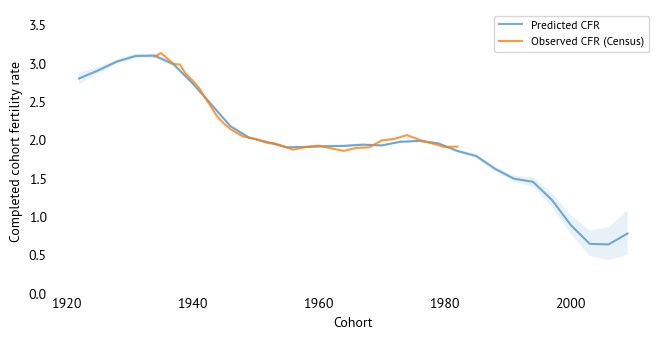

In [28]:
# Shift cfr_cps from observation year to birth cohort
# cfr_cps is indexed by survey year (when women were age 40-44)
# To get birth cohort, subtract the age (approximately cfr_age)
cfr_cps_cohort = pd.Series(cfr_cps.values, cfr_cps.index - cfr_age, copy=True)

# Plot both observed and predicted CFR with cohort on x-axis
plt.fill_between(hdi_lower.index, hdi_lower[cfr_age], hdi_upper[cfr_age], alpha=0.1)
cfr_cohort.plot(label="Predicted CFR", alpha=0.6)
cfr_cps_cohort.plot(label="Observed CFR (Census)", alpha=0.8)
decorate(xlabel="Cohort", ylabel="Completed cohort fertility rate", ylim=[0, 3.7])
plt.savefig('../jb/figs/cfr_vs_actual_v4.png', dpi=150, bbox_inches='tight')

The model predicts that CFR will decline steeply, starting with women born around 1980, and reaching very low levels for the most recent cohorts.

The error bounds show 94% credible intervals that take into account the uncertainty of the estimated coefficients, but we should not take them too seriously because they don't take into account the far larger source of uncertainty -- any number of things that could happen in the future that would affect these outcomes.

I suggest we think of these results as projections rather than predictions -- that is, they show us what we would expect in the future if the structure of the model is appropriate, the estimated parameters are accurate, and nothing changes in the future that substantially affects the outcome.

Considering the structure of the model, the most obvious omission is the possibility of a "rebound" effect, where a cohort that has fewer children when they are young goes on to have more children when they are older, with the effect of closing the CFR gap with previous generations.

Of course that could happen, and possible extensions to the model could either add an interaction term that estimates the rebound in previous generations, or a "what if" parameter that lets us explore the effect of different levels of rebound on future CFR.

We can come back to this question, but first let's consider whether the model has adequately captured the structure of the data.

The results show that, unless there is a substantial shift toward higher fertility, starting soon, we should expect a large decline in CFR for cohorts currently in their reproductive years. The rate of decline is comparable in magnitude to the decline following the baby boom.

Of course, projections several decades into the future are unlikely to be precise, but the model suggests that CFR for recent cohorts could reach very low levels, comparable to the lowest fertility countries today.
At such levels, barring large-scale immigration, the population of the United States would decline substantially.

## Compare model to data

The following function plots observed average parity in each cohort-age group along with the estimates from the model.
Where we have data, we can see if the retrodictions fit it.
And where we are missing data, we can see if the predictions seem plausible.

In [29]:
def plot_cohorts(mean_parity_df, start, end):
    cohorts = mean_parity_df.index[start:end]
    palette = list(sns.color_palette("nipy_spectral", len(cohorts)))

    for i, cohort in enumerate(cohorts):
        mean_parity_df.loc[cohort].plot(
            style="o", color=palette[i], alpha=0.8, label=cohort
        )
        mean_cumulative_rate.loc[cohort].plot(
            style=":", color=palette[i], alpha=0.6, label=""
        )

    decorate(xlabel="Age")

Here are the results for women born in the 1990s and 2000s.

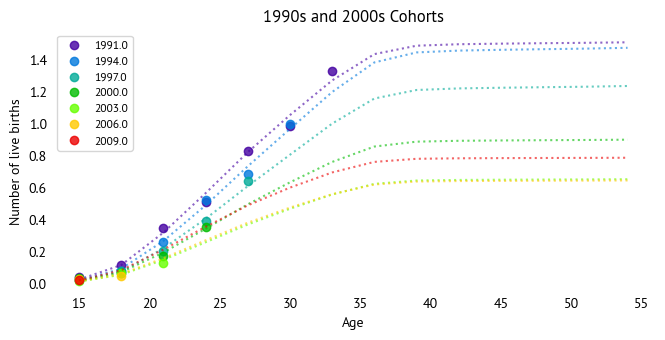

In [30]:
mean_parity_df = sum_df / count_df

plot_cohorts(mean_parity_df, -7, None)
decorate(ylabel="Number of live births", title="1990s and 2000s Cohorts")
plt.savefig('../jb/figs/cohorts_1990s_2000s.png', dpi=150, bbox_inches='tight')

Looking at the cohorts with the most data, we can see that the retrodictions fit the observed data well.

In [31]:
# Example: Check parity at age 33 and predicted CFR
# mean_parity_df.loc[1991, 33], mean_cumulative_rate.loc[1991, cfr_age]

As expected, predicted CFRs for successive cohorts are lower.
The projections for the last two cohorts overlap because the estimates for their cohort effects are almost the same.

Here are the results for women born in the 1970s and 1980s.

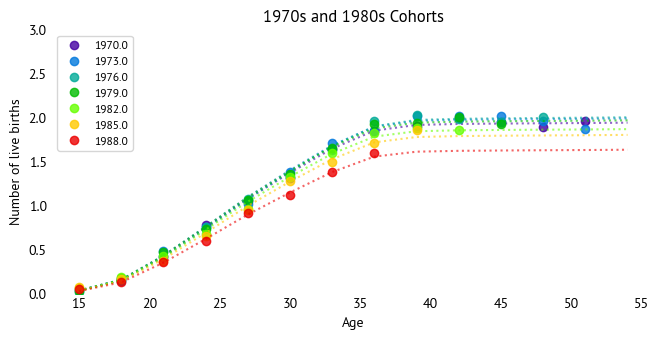

In [32]:
plot_cohorts(mean_parity_df, -14, -7)
decorate(ylim=[0, 3], ylabel="Number of live births", title="1970s and 1980s Cohorts")
plt.savefig('../jb/figs/cohorts_1970s_1980s.png', dpi=150, bbox_inches='tight')

The model seems to capture the structure of the data well.
Here are the results for women born in the 1950s and 1960s.

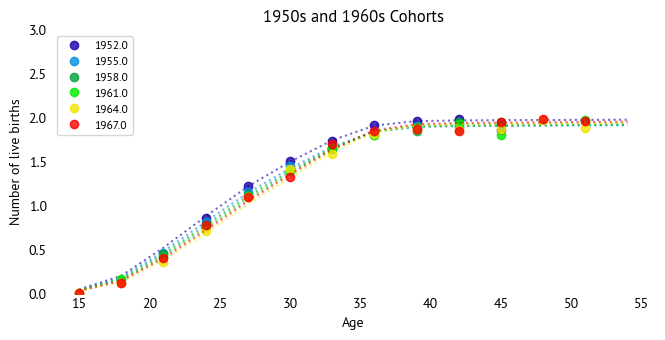

In [33]:
plot_cohorts(mean_parity_df, -20, -14)
decorate(ylim=[0, 3], ylabel="Number of live births", title="1950s and 1960s Cohorts")

The estimated CFRs for these cohorts are not very different.

Finally here are the results for women born in the 1940s and the end of the 1930s.

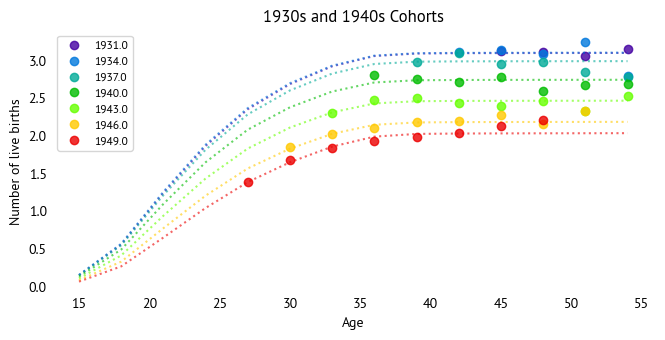

In [34]:
plot_cohorts(mean_parity_df, -27, -20)
decorate(ylabel="Number of live births", title="1930s and 1940s Cohorts")

Here we see the decline in total fertility that characterized the end of the baby boom.

Overall, the model seems to capture the structure of the data, and its projections are plausible in the sense that they are based on the assumption that the future will be like the past.

## Regression testing

In [35]:
# Save baseline results for regression testing
# Use the same cfr_age as defined above (42, to match CPS range 40-44)
# cfr_age is already defined earlier in the notebook

# Prepare CFR data with HDI bounds
cfr_df = pd.DataFrame({
    'cohort': cohort_labels,
    'mean': mean_cumulative_rate[cfr_age].values,
    'hdi_lower': hdi_lower[cfr_age].values,
    'hdi_upper': hdi_upper[cfr_age].values
})

# Save all three outputs as v4.0
model_version = "v4.0"
save_baseline_results(
    version=model_version,
    alpha_summary=alpha_summary,
    beta_summary=beta_summary,
    cfr_df=cfr_df,
    cohort_labels=cohort_labels,
    age_labels=age_labels
)

log_and_print(f"Saved regression test results as {model_version}")
log_and_print(f"  Saved to: notebooks/results/fertility_cps_{model_version}.h5")
log_and_print("")

Saved baseline results to results/fertility_cps_v4.0.h5
Saved regression test results as v4.0
  Saved to: notebooks/results/fertility_cps_v4.0.h5



In [36]:
# Load v3.0 results and compare with v4.0
baseline = load_baseline_results("v3.0")

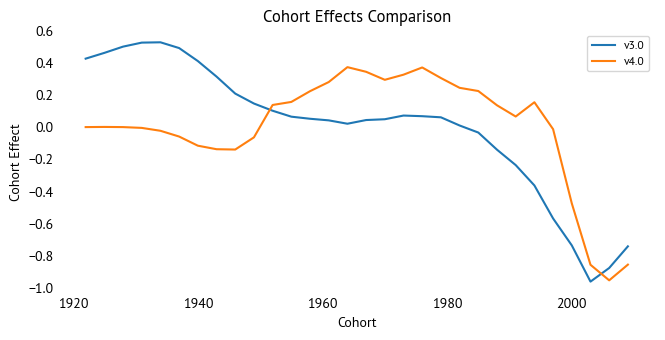

In [37]:
# Compare cohort effects
plt.plot(baseline['alpha']['cohort'], baseline['alpha']['mean'], label='v3.0')
plt.plot(cohort_labels, alpha_summary['mean'], label='v4.0')
decorate(xlabel='Cohort', ylabel='Cohort Effect', title='Cohort Effects Comparison')
plt.savefig('../jb/figs/comparison_cohort_effects.png', dpi=150, bbox_inches='tight')

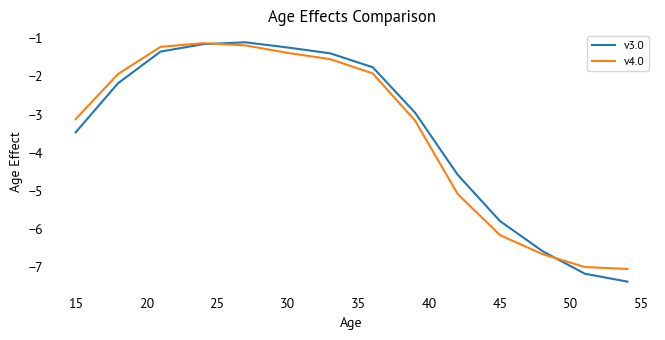

In [38]:
# Compare age effects
plt.plot(baseline['beta']['age'], baseline['beta']['mean'], label='v3.0')
plt.plot(age_labels, beta_summary['mean'], label='v4.0')
decorate(xlabel='Age', ylabel='Age Effect', title='Age Effects Comparison')
plt.savefig('../jb/figs/comparison_age_effects.png', dpi=150, bbox_inches='tight')

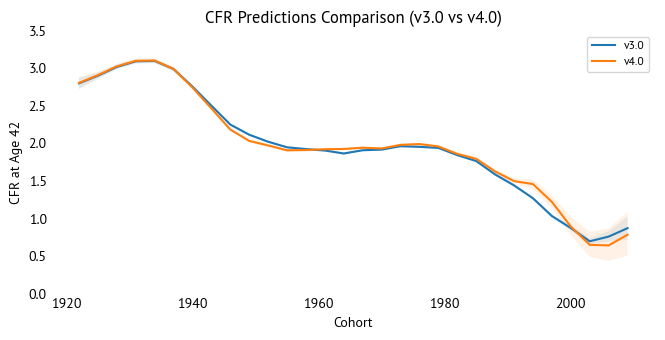

In [39]:
# Compare CFR predictions with error bounds

# Plot v3.0 with error bounds
plt.fill_between(baseline['cfr_df']['cohort'], 
                 baseline['cfr_df']['hdi_lower'], 
                 baseline['cfr_df']['hdi_upper'], 
                 alpha=0.1)
plt.plot(baseline['cfr_df']['cohort'], baseline['cfr_df']['mean'], 
         label='v3.0')

# Plot v4.0 with error bounds
plt.fill_between(cohort_labels, 
                 hdi_lower[cfr_age], 
                 hdi_upper[cfr_age], 
                 alpha=0.1)
plt.plot(cohort_labels, mean_cumulative_rate[cfr_age], 
         label='v4.0')

decorate(xlabel='Cohort', 
         ylabel=f'CFR at Age {cfr_age}', 
         title='CFR Predictions Comparison (v3.0 vs v4.0)',
         ylim=[0, 3.5])
plt.savefig('../jb/figs/comparison_cfr_v4.png', dpi=150, bbox_inches='tight')

In [40]:
# Analyze correlation between alpha and gamma for young cohorts
log_and_print("")
log_and_print("=" * 80)
log_and_print("Analysis: Alpha-Gamma Correlation for Young Cohorts")
log_and_print("=" * 80)
log_and_print("")

# Select last 8 cohorts
n_cohorts_to_analyze = 8
last_cohort_indices = list(range(len(cohort_labels) - n_cohorts_to_analyze, len(cohort_labels)))
last_cohorts = cohort_labels[last_cohort_indices]

log_and_print(f"Analyzing last {n_cohorts_to_analyze} cohorts: {last_cohorts[0]} to {last_cohorts[-1]}")
log_and_print("")

# Extract alpha and gamma for all cohorts from posterior
alpha_samples = idata.posterior["alpha"].values  # shape: (chains, draws, cohorts)
gamma_samples = idata.posterior["gamma"].values  # shape: (chains, draws, cohorts)

# Flatten chains and draws
alpha_flat = alpha_samples.reshape(-1, alpha_samples.shape[-1])  # shape: (samples, cohorts)
gamma_flat = gamma_samples.reshape(-1, gamma_samples.shape[-1])  # shape: (samples, cohorts)


Analysis: Alpha-Gamma Correlation for Young Cohorts

Analyzing last 8 cohorts: 1988 to 2009



In [41]:
# Create table showing observed age ranges for each cohort
log_and_print("Observed age ranges for each cohort:")
log_and_print("-" * 80)
log_and_print(f"{'Cohort':<8} {'Min Age':<10} {'Max Age':<10} {'# Ages':<10} {'Age Range'}")
log_and_print("-" * 80)

# Create a dataframe with observed age information
observed_ages_data = []

for i, cohort_idx in enumerate(last_cohort_indices):
    cohort = cohort_labels[cohort_idx]
    
    # Find which ages have been observed (non-zero counts or non-NaN sums)
    cohort_counts = count_array[cohort_idx, :]
    cohort_sums = sum_array[cohort_idx, :]
    
    # Ages with actual observations (non-zero counts and non-NaN sums)
    observed_mask = (cohort_counts > 0) & (~np.isnan(cohort_sums))
    observed_age_indices = np.where(observed_mask)[0]
    
    if len(observed_age_indices) > 0:
        observed_ages = age_labels[observed_age_indices]
        min_age = observed_ages.min()
        max_age = observed_ages.max()
        n_ages = len(observed_ages)
        age_range_str = f"{min_age}-{max_age}"
        
        observed_ages_data.append({
            'cohort': cohort,
            'min_age': min_age,
            'max_age': max_age,
            'n_ages': n_ages,
            'age_range': age_range_str,
            'ages_list': list(observed_ages)
        })
        
        marker = " ***" if i >= 4 else ""  # Mark last 4 cohorts
        log_and_print(f"{cohort:<8d} {min_age:<10d} {max_age:<10d} {n_ages:<10d} {age_range_str}{marker}")
    else:
        observed_ages_data.append({
            'cohort': cohort,
            'min_age': np.nan,
            'max_age': np.nan,
            'n_ages': 0,
            'age_range': 'No data',
            'ages_list': []
        })
        log_and_print(f"{cohort:<8d} {'N/A':<10} {'N/A':<10} {0:<10d} No data")

log_and_print("-" * 80)
log_and_print("*** = Last 4 cohorts (youngest)")
log_and_print("")

# Create a pandas DataFrame for easier manipulation
observed_ages_df = pd.DataFrame(observed_ages_data)

# Calculate additional useful metrics
log_and_print("Key observations:")
for i, row in observed_ages_df.iterrows():
    cohort = row['cohort']
    if row['n_ages'] > 0:
        # Calculate what fraction of reproductive years observed
        # Assuming reproductive years are roughly 15-44
        reproductive_span = 30  # ages 15-44
        observed_span = row['max_age'] - row['min_age'] + 1
        fraction_observed = observed_span / reproductive_span
        
        marker = " ***" if i >= 4 else ""
        log_and_print(f"  Cohort {cohort}: Observed {observed_span}/{reproductive_span} years "
                     f"({fraction_observed:.1%} of reproductive span){marker}")

log_and_print("")

Observed age ranges for each cohort:
--------------------------------------------------------------------------------
Cohort   Min Age    Max Age    # Ages     Age Range
--------------------------------------------------------------------------------
1988     15         36         8          15-36
1991     15         33         7          15-33
1994     15         30         6          15-30
1997     15         27         5          15-27
2000     15         24         4          15-24 ***
2003     15         21         3          15-21 ***
2006     15         18         2          15-18 ***
2009     15         15         1          15-15 ***
--------------------------------------------------------------------------------
*** = Last 4 cohorts (youngest)

Key observations:
  Cohort 1988: Observed 22/30 years (73.3% of reproductive span)
  Cohort 1991: Observed 19/30 years (63.3% of reproductive span)
  Cohort 1994: Observed 16/30 years (53.3% of reproductive span)
  Cohort 1997: Observe

  Saved: ../jb/figs/observed_age_ranges.png



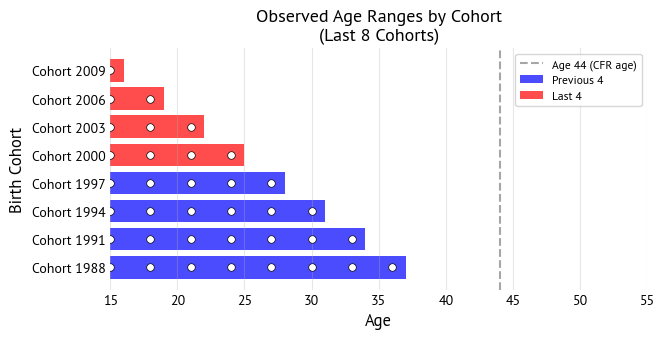

In [42]:
# Visualize observed age ranges
fig, ax = plt.subplots()

# Plot observed age ranges as horizontal bars
for i, row in observed_ages_df.iterrows():
    cohort = row['cohort']
    if row['n_ages'] > 0:
        # Color differently for last 4 vs previous 4
        color = 'red' if i >= 4 else 'blue'
        alpha = 0.7
        
        # Draw a horizontal bar from min to max age
        ax.barh(i, row['max_age'] - row['min_age'] + 1, 
                left=row['min_age'], height=0.8, 
                color=color, alpha=alpha, 
                label='Last 4' if (i == 4) else ('Previous 4' if i == 0 else ''))
        
        # Add dots for each observed age
        ages = np.array(row['ages_list'])
        ax.scatter(ages, [i] * len(ages), color='white', s=30, zorder=3, 
                  edgecolors='black', linewidths=0.5)

# Add vertical line at age 44 (end of main reproductive years)
ax.axvline(44, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Age 44 (CFR age)')

# Formatting
ax.set_yticks(range(len(observed_ages_df)))
ax.set_yticklabels([f"Cohort {c}" for c in observed_ages_df['cohort']])
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Birth Cohort', fontsize=12)
ax.set_title('Observed Age Ranges by Cohort\n(Last 8 Cohorts)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, axis='x', alpha=0.3)
ax.set_xlim(15, 55)

plt.tight_layout()
plt.savefig('../jb/figs/observed_age_ranges.png', dpi=150, bbox_inches='tight')
log_and_print("  Saved: ../jb/figs/observed_age_ranges.png")
decorate()

log_and_print("")

In [43]:
# Compute posterior correlations between alpha and gamma for each cohort
log_and_print("Posterior correlations between alpha and gamma:")
log_and_print("-" * 60)
for i, cohort in enumerate(cohort_labels):
    corr = np.corrcoef(alpha_flat[:, i], gamma_flat[:, i])[0, 1]
    if i >= len(cohort_labels) - n_cohorts_to_analyze:
        log_and_print(f"  Cohort {cohort:4d}: r = {corr:7.4f} ***")
    else:
        log_and_print(f"  Cohort {cohort:4d}: r = {corr:7.4f}")

log_and_print("")
log_and_print("*** = Last 8 cohorts")
log_and_print("")

# Store correlations for plotting
correlations = []
for i, cohort in enumerate(cohort_labels):
    corr = np.corrcoef(alpha_flat[:, i], gamma_flat[:, i])[0, 1]
    correlations.append(corr)

Posterior correlations between alpha and gamma:
------------------------------------------------------------
  Cohort 1922: r =  0.9917
  Cohort 1925: r =  0.9936
  Cohort 1928: r =  0.9939
  Cohort 1931: r =  0.9935
  Cohort 1934: r =  0.9927
  Cohort 1937: r =  0.9898
  Cohort 1940: r =  0.9852
  Cohort 1943: r =  0.9737
  Cohort 1946: r =  0.9609
  Cohort 1949: r =  0.9562
  Cohort 1952: r =  0.9586
  Cohort 1955: r =  0.9543
  Cohort 1958: r =  0.9545
  Cohort 1961: r =  0.9518
  Cohort 1964: r =  0.9527
  Cohort 1967: r =  0.9512
  Cohort 1970: r =  0.9504
  Cohort 1973: r =  0.9510
  Cohort 1976: r =  0.9521
  Cohort 1979: r =  0.9517
  Cohort 1982: r =  0.9528
  Cohort 1985: r =  0.9547
  Cohort 1988: r =  0.9553 ***
  Cohort 1991: r =  0.9550 ***
  Cohort 1994: r =  0.9670 ***
  Cohort 1997: r =  0.9670 ***
  Cohort 2000: r =  0.9729 ***
  Cohort 2003: r =  0.9804 ***
  Cohort 2006: r =  0.9741 ***
  Cohort 2009: r =  0.9098 ***

*** = Last 8 cohorts



  Saved: ../jb/figs/alpha_gamma_correlation_by_cohort.png

U-shaped pattern interpretation:
  - Oldest cohorts (pre-1945): High correlation - observed only post-reproduction
  - Middle cohorts (1945-1985): Lower correlation - complete reproductive data
  - Minimum at cohort 2009 (r=0.9098) - best data quality
  - Recent cohorts (1985+): Increasing correlation - limited early observations
  - High correlation indicates model cannot distinguish quantum from tempo



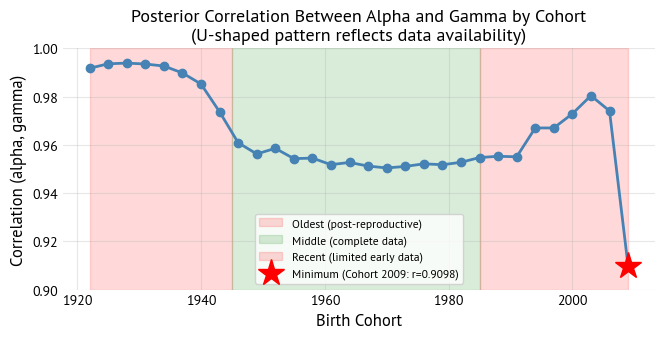

In [44]:
# Plot correlation vs cohort to show U-shaped pattern
fig, ax = plt.subplots()

# Plot correlation vs cohort
ax.plot(cohort_labels, correlations, 'o-', linewidth=2, markersize=6, color='steelblue')

# Highlight different regions
oldest_cutoff = 1945
youngest_cutoff = 1985

# Shade regions
ax.axvspan(cohort_labels[0], oldest_cutoff, alpha=0.15, color='red', 
           label='Oldest (post-reproductive)')
ax.axvspan(oldest_cutoff, youngest_cutoff, alpha=0.15, color='green', 
           label='Middle (complete data)')
ax.axvspan(youngest_cutoff, cohort_labels[-1], alpha=0.15, color='red', 
           label='Recent (limited early data)')

# Find and mark minimum correlation
min_corr_idx = np.argmin(correlations)
min_corr_cohort = cohort_labels[min_corr_idx]
min_corr_value = correlations[min_corr_idx]
ax.plot(min_corr_cohort, min_corr_value, 'r*', markersize=20, 
        label=f'Minimum (Cohort {min_corr_cohort}: r={min_corr_value:.4f})')

# Formatting
ax.set_xlabel('Birth Cohort', fontsize=12)
ax.set_ylabel('Correlation (alpha, gamma)', fontsize=12)
ax.set_title('Posterior Correlation Between Alpha and Gamma by Cohort\n(U-shaped pattern reflects data availability)', 
             fontsize=13)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0.9, 1.0)

plt.tight_layout()
plt.savefig('../jb/figs/alpha_gamma_correlation_by_cohort.png', dpi=150, bbox_inches='tight')
log_and_print("  Saved: ../jb/figs/alpha_gamma_correlation_by_cohort.png")
decorate()

log_and_print("")
log_and_print("U-shaped pattern interpretation:")
log_and_print("  - Oldest cohorts (pre-1945): High correlation - observed only post-reproduction")
log_and_print("  - Middle cohorts (1945-1985): Lower correlation - complete reproductive data")
log_and_print(f"  - Minimum at cohort {min_corr_cohort} (r={min_corr_value:.4f}) - best data quality")
log_and_print("  - Recent cohorts (1985+): Increasing correlation - limited early observations")
log_and_print("  - High correlation indicates model cannot distinguish quantum from tempo")
log_and_print("")

  Saved: ../jb/figs/alpha_gamma_scatter_comparison.png


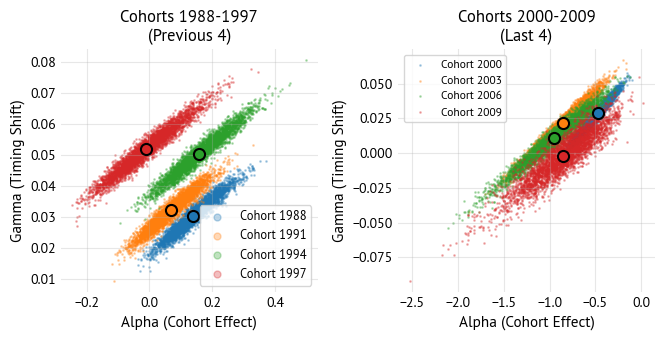

In [45]:
# Create scatter plots comparing alpha vs gamma for last 4 vs previous 4 cohorts
fig, axes = plt.subplots(1, 2)

# Previous 4 cohorts (cohorts -8 to -5)
prev_4_indices = last_cohort_indices[:4]
prev_4_cohorts = cohort_labels[prev_4_indices]

ax = axes[0]
for i, cohort_idx in enumerate(prev_4_indices):
    ax.scatter(alpha_flat[:, cohort_idx], gamma_flat[:, cohort_idx], 
               alpha=0.3, s=1, label=f'Cohort {cohort_labels[cohort_idx]}')
    corr = np.corrcoef(alpha_flat[:, cohort_idx], gamma_flat[:, cohort_idx])[0, 1]
    # Add mean point
    ax.plot(alpha_flat[:, cohort_idx].mean(), gamma_flat[:, cohort_idx].mean(), 
            'o', markersize=8, markeredgecolor='black', markeredgewidth=1.5)
ax.set_xlabel('Alpha (Cohort Effect)', fontsize=11)
ax.set_ylabel('Gamma (Timing Shift)', fontsize=11)
ax.set_title(f'Cohorts {prev_4_cohorts[0]}-{prev_4_cohorts[-1]}\n(Previous 4)', fontsize=12)
ax.legend(fontsize=9, markerscale=5)
ax.grid(True, alpha=0.3)

# Last 4 cohorts (cohorts -4 to -1)
last_4_indices = last_cohort_indices[4:]
last_4_cohorts = cohort_labels[last_4_indices]

ax = axes[1]
for i, cohort_idx in enumerate(last_4_indices):
    ax.scatter(alpha_flat[:, cohort_idx], gamma_flat[:, cohort_idx], 
               alpha=0.3, s=1, label=f'Cohort {cohort_labels[cohort_idx]}')
    corr = np.corrcoef(alpha_flat[:, cohort_idx], gamma_flat[:, cohort_idx])[0, 1]
    # Add mean point
    ax.plot(alpha_flat[:, cohort_idx].mean(), gamma_flat[:, cohort_idx].mean(), 
            'o', markersize=8, markeredgecolor='black', markeredgewidth=1.5)
ax.set_xlabel('Alpha (Cohort Effect)', fontsize=11)
ax.set_ylabel('Gamma (Timing Shift)', fontsize=11)
ax.set_title(f'Cohorts {last_4_cohorts[0]}-{last_4_cohorts[-1]}\n(Last 4)', fontsize=12)
ax.legend(fontsize=9, markerscale=5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../jb/figs/alpha_gamma_scatter_comparison.png', dpi=150, bbox_inches='tight')
log_and_print("  Saved: ../jb/figs/alpha_gamma_scatter_comparison.png")
decorate()

In [46]:
# Interpretation of alpha-gamma correlations
log_and_print("")
log_and_print("Interpretation:")
log_and_print("  - Negative correlation: Lower alpha (fertility) associated with higher gamma (later childbearing)")
log_and_print("  - This suggests the model struggles to distinguish quantum from tempo for young cohorts")
log_and_print("  - Observed low early fertility could be explained by multiple (alpha, gamma) combinations")
log_and_print("")


Interpretation:
  - Negative correlation: Lower alpha (fertility) associated with higher gamma (later childbearing)
  - This suggests the model struggles to distinguish quantum from tempo for young cohorts
  - Observed low early fertility could be explained by multiple (alpha, gamma) combinations



In [47]:
# Close debug log
log_and_print("")
log_and_print("=" * 80)
log_and_print("Model fitting complete")
debug_log.close()
print(f"Debug log saved to ../jb/tables/fertility_cps4_log.txt")


Model fitting complete
Debug log saved to ../jb/tables/fertility_cps4_log.txt


In [48]:
from utils import beep

beep()